Dataset address:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

# Import packages

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score, recall_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

# Import dataset

In [2]:
path_train = '/Users/yuwensun/Documents/编程/Kaggle/house-prices-advanced-regression-techniques/train.csv'
path_test = '/Users/yuwensun/Documents/编程/Kaggle/house-prices-advanced-regression-techniques/test.csv'
df_train = pd.read_csv(path_train)
df_train['SalePrice'] = np.log(df_train['SalePrice'])
df_test = pd.read_csv(path_test)

# print(df_train.to_string())

df_full = pd.concat([df_train, df_test], keys = ['train', 'test'])

#  Id
df_full.drop("Id", axis = 1, inplace=True)

unable_deal_features = ['MiscFeature', 'MiscVal']
df_full.drop(unable_deal_features, axis = 1, inplace=True)

# print(df_full.dtypes.to_string())
print(df_full.to_string())

            MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence  MoSold  YrSold SaleType SaleCondition  SalePrice
train 0             60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   

# Exploratory Data analysis

## Handling missing values

### 1. Make some specific column feature variables fillings

In [3]:
target = "SalePrice"
num_feature_with_mode = ['MasVnrArea', 'BsmtFinSF2', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
cat_feature_with_nan = ['Alley', 'FireplaceQu', 'GarageQual', 'PoolQC', 'Fence']
disc_features = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']

for feature in num_feature_with_mode+disc_features:
    df_full[feature].fillna(df_full[feature].mode()[0], inplace=True)

for feature in cat_feature_with_nan:
    df_full[feature].fillna("None", inplace=True)

### 2. Drop columns and rows by missing values

In [4]:
# Drop columns with over 'threshold' number of NaN values
threshold = 0.3
null_count = df_full.isnull().sum() / len(df_full)
dropped = null_count[null_count > threshold].index.to_list() # Dropped column list. Over 30% of values are NaN values.
dropped.remove(target)
print(f"Dropped columns with over 30% NaN values are: {dropped}")
# print("---------------------------------------------------------")
df_full.drop(dropped, axis = 1, inplace=True)

# Drop rows whose column has little missing values between (0, 0.05)
df_train = df_full.loc['train'].copy()
df_test = df_full.loc['test'].copy()
null_count = df_train.isnull().sum() / len(df_train)

columns = null_count[(null_count > 0) & (null_count < 0.03)].index.to_list()
df_train.dropna(subset = columns, axis = 0, inplace=True)
print(f"Columns having missing values percentage between (0, 0.03) are: {columns}")
df_full = pd.concat([df_train, df_test], keys = ['train', 'test'])
# df_full_dropped.shape

Dropped columns with over 30% NaN values are: []
Columns having missing values percentage between (0, 0.03) are: ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical']


### 3. Filling missing values of num (non-discrete and non_with_mode), cat

In [5]:
# Missed value columns
null_count = df_full.isnull().sum() / len(df_full)
missvalue_index = null_count[null_count != 0].index.to_list()
print(f"Missed values are {missvalue_index}")

# df_full_X_dropped[missvalue_index].dtypes
# df_full_X_dropped[missvalue_index]
missvalue_index_num = [f for f in missvalue_index if (df_full.dtypes[f] != 'object')]
missvalue_index_cat = [f for f in missvalue_index if (df_full.dtypes[f] == 'object')]
print(f"Numercial columns are going to fill missing values are: {missvalue_index_num}")
print(f"Categorical columns are going to fill missing values are: {missvalue_index_cat}")

Missed values are ['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageArea', 'GarageCond', 'SaleType', 'SalePrice']
Numercial columns are going to fill missing values are: ['LotFrontage', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'SalePrice']
Categorical columns are going to fill missing values are: ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageCond', 'SaleType']


#### - Numeric values (non-discrete and non_with_mode)

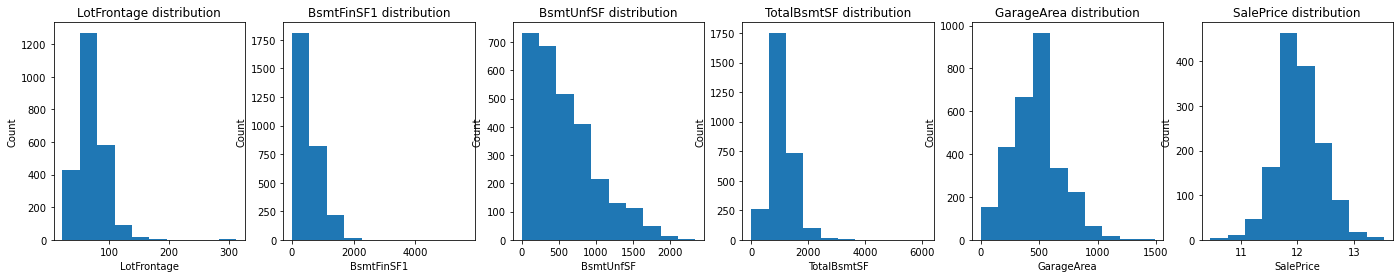

In [6]:
# Dealing with missing values of num categories
fig, ax = plt.subplots(1,len(missvalue_index_num), figsize = (4 * len(missvalue_index_num), 4))
for index in missvalue_index_num:
    i = missvalue_index_num.index(index)
    ax[i].hist(df_full.loc[(~df_full[index].isnull()), index])
    ax[i].set_title(index + ' distribution')
    ax[i].set_xlabel(index)
    ax[i].set_ylabel('Count')

## After seeing all histograms, because it has some outliers, so we'd better to use median for missing values 
for index in missvalue_index_num:
    df_full[index].fillna(df_full[index].median(skipna = True), inplace = True)

# df_train_X_dropped[missvalue_index_num].info()

#### - Categorical values

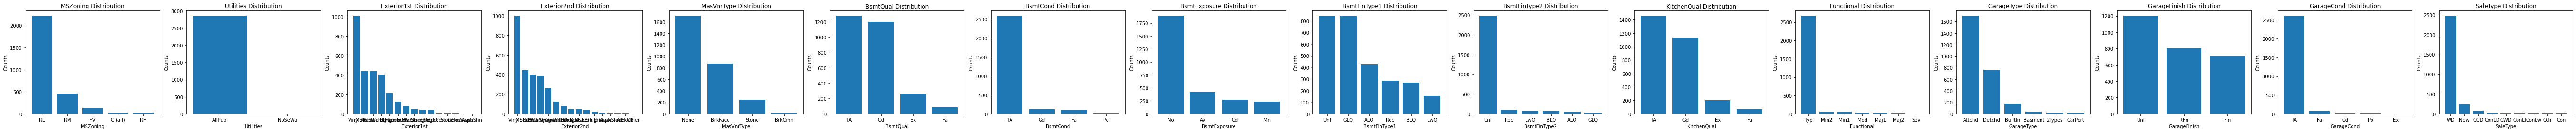

In [7]:
fix, ax = plt.subplots(1,len(missvalue_index_cat), figsize = (6 * len(missvalue_index_cat),4))

for index in missvalue_index_cat:
    i = missvalue_index_cat.index(index)

    feature_counts = df_full.loc[~df_full[index].isnull(), index].value_counts()
    features = feature_counts.index.to_list()
    counts = feature_counts.to_list()

    ax[i].bar(features, counts)
    ax[i].set_title(index + ' Distribution')
    ax[i].set_xlabel(index)
    ax[i].set_ylabel('Counts')

# filling categorical missing values
for index in missvalue_index_cat:
    df_full[index].replace(np.nan, df_full[index].mode(dropna = True)[0], inplace = True)

# df_train_dropped.isnull().sum()[df_train_dropped.isnull().sum() != 0]

In [8]:
df_full
# sum(df_full.isnull().sum())

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
train 0             60       RL         65.0     8450   Pave  None      Reg   
      1             20       RL         80.0     9600   Pave  None      Reg   
      2             60       RL         68.0    11250   Pave  None      IR1   
      3             70       RL         60.0     9550   Pave  None      IR1   
      4             60       RL         84.0    14260   Pave  None      IR1   
...                ...      ...          ...      ...    ...   ...      ...   
test  1454         160       RM         21.0     1936   Pave  None      Reg   
      1455         160       RM         21.0     1894   Pave  None      Reg   
      1456          20       RL        160.0    20000   Pave  None      Reg   
      1457          85       RL         62.0    10441   Pave  None      Reg   
      1458          60       RL         74.0     9627   Pave  None      Reg   

           LandContour Utilities LotConfig  ... 3SsnPorch ScreenPorch  \
train 0            Lvl    AllPub    Inside  ...         0           0   
      1            Lvl    AllPub       FR2  ...         0           0   
      2            Lvl    AllPub    Inside  ...         0           0   
      3            Lvl    AllPub    Corner  ...         0           0   
      4            Lvl    AllPub       FR2  ...         0           0   
...                ...       ...       ...  ...       ...         ...   
test  1454         Lvl    AllPub    Inside  ...         0           0   
      1455         Lvl    AllPub    Inside  ...         0           0   
      1456         Lvl    AllPub    Inside  ...         0           0   
      1457         Lvl    AllPub    Inside  ...         0           0   
      1458         Lvl    AllPub    Inside  ...         0           0   

           PoolArea PoolQC  Fence MoSold  YrSold  SaleType  SaleCondition  \
train 0           0   None   None      2    2008        WD         Normal   
      1           0   None   None      5    2007        WD         Normal   
      2           0   None   None      9    2008        WD         Normal   
      3           0   None   None      2    2006        WD        Abnorml   
      4           0   None   None     12    2008        WD         Normal   
...             ...    ...    ...    ...     ...       ...            ...   
test  1454        0   None   None      6    2006        WD         Normal   
      1455        0   None   None      4    2006        WD        Abnorml   
      1456        0   None   None      9    2006        WD        Abnorml   
      1457        0   None  MnPrv      7    2006        WD         Normal   
      1458        0   None   None     11    2006        WD         Normal   

            SalePrice  
train 0     12.247694  
      1     12.109011  
      2     12.317167  
      3     11.849398  
      4     12.429216  
...               ...  
test  1454  12.011273  
      1455  12.011273  
      1456  12.011273  
      1457  12.011273  
      1458  12.011273  

[2871 rows x 78 columns]

# Data Preprocessing

## Drop collinear columns

In [9]:
## Split into numeric and categorical data
target = 'SalePrice'
# df_full[disc_features] = df_full[disc_features].astype(str)

# Numeric features
num_features = [f for f in df_full.dtypes.index.to_list() if (df_full.dtypes[f] != 'object')]
num_features.remove(target)
print(f"Length: {len(num_features)}, {num_features}")

# Categorical features
cat_features = [f for f in df_full.dtypes.index.to_list() if (df_full.dtypes[f] == 'object')]
cat_features
print(f"Length: {len(cat_features)}, {cat_features}")

df_full.dtypes

Length: 35, ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold']
Length: 42, ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 78, dtype: object

In [10]:
# Drop > threshold variables
# print(df_full.dtypes)
df_train = df_full.loc['train']
df = df_train.drop(target, axis=1)
corr = df.corr()
# sns.pairplot(df_train_dropped[num_features])
corr
drop_lst = []; threshold = 0.6
for i in range(len(corr)): # traverse rows
    for j in range(i+1, len(corr)): # traverse columns after column i
        if (corr.index.to_list()[i] not in drop_lst) & (abs(corr.iloc[i, j]) > 0.6): # after drop some column, no need to traverse its correpsonding row afterwards
            if corr.columns.to_list()[j] not in drop_lst:
                # drop_lst.append((corr.index.to_list()[i], corr.columns.to_list()[j])) # drop column list
                print((corr.index.to_list()[i], corr.columns.to_list()[j]))


drop_lst = ['GarageCars', 'GarageYrBlt', 'BsmtFullBath', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr']
# corr
df_full.drop(drop_lst, axis=1, inplace=True)
print(df_full.to_string())

('OverallQual', 'GarageCars')
('YearBuilt', 'GarageYrBlt')
('BsmtFinSF1', 'BsmtFullBath')
('TotalBsmtSF', '1stFlrSF')
('2ndFlrSF', 'GrLivArea')
('2ndFlrSF', 'HalfBath')
('2ndFlrSF', 'TotRmsAbvGrd')
('GrLivArea', 'FullBath')
('GrLivArea', 'TotRmsAbvGrd')
('BedroomAbvGr', 'TotRmsAbvGrd')
('GarageCars', 'GarageArea')
            MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  LowQualFinSF  BsmtHalfBath  FullBath  HalfBath  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType GarageFinish  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  

## Encoding categorical variables

In [11]:
num_features = [f for f in df_full.dtypes.index.to_list() if (df_full.dtypes[f] != 'object')]
num_features.remove(target)
print(f"Length: {len(num_features)}, {num_features}")

# Categorical features
cat_features = [f for f in df_full.dtypes.index.to_list() if (df_full.dtypes[f] == 'object')]
cat_features
print(f"Length: {len(cat_features)}, {cat_features}")

Length: 28, ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold']
Length: 42, ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType', 'SaleCondition']


In [12]:
# df_train = df_full.loc['train']
# df_test = df_full.loc['test']
# print(df_train['Exterior1st'].value_counts().sort_values())
# print('-------')
# print(df_test['Exterior1st'].value_counts().sort_values())

In [13]:
# Train-test split 
df_train = df_full.loc['train']
X_test = df_full.loc['test'].drop(target, axis=1)

X_dev = df_train.drop(target, axis=1)
y_dev = df_train[target]

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=42)

# Encoding
for feature in cat_features:
    enc = OrdinalEncoder(categories = [X_train[feature].unique().tolist()], 
                         handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[feature] = enc.fit_transform(X_train[feature].to_numpy().reshape(-1,1))
    X_val[feature] = enc.fit_transform(X_val[feature].to_numpy().reshape(-1,1))
    X_test[feature] = enc.transform(X_test[feature].to_numpy().reshape(-1,1))

# Train-dev-test split

In [14]:
# df_train = df_full.loc['train']
# X_test = df_full.loc['test'].drop(target, axis=1)

# X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=42)

# Scaling for numeric variables

In [15]:
print(sorted(disc_features))
print(sorted(num_features))

['BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'Fireplaces', 'FullBath', 'GarageCars', 'GarageYrBlt', 'HalfBath', 'KitchenAbvGr', 'MSSubClass', 'MoSold', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'YrSold']
['3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']


In [16]:
ss = StandardScaler()
# X_train[num_features] = ss.fit_transform(X_train[num_features])
# X_val[num_features] = ss.transform(X_val[num_features])
# X_test[num_features] = ss.transform(X_test[num_features])
for f in ['GarageCars', 'GarageYrBlt', 'BedroomAbvGr', 'BsmtFullBath']:
    disc_features.remove(f)

for f in disc_features:
    num_features.remove(f)

X_train[num_features] = ss.fit_transform(X_train[num_features])
X_val[num_features] = ss.transform(X_val[num_features])
X_test[num_features] = ss.transform(X_test[num_features])

In [17]:
# Hyperparameter tunning
rf = RandomForestRegressor(random_state=42)
hyper = {'n_estimators': np.arange(40, 200, 2),
         'max_depth': np.arange(5,20, 1)}

rfcv = GridSearchCV(rf, hyper, cv = 10)
rfcv.fit(X_train, y_train)

In [ ]:
rfcv.best_estimator_

RandomForestRegressor(max_depth=15, n_estimators=170, random_state=42)

# Model selection

## Random Forest

In [ ]:
X_test

MSSubClass  MSZoning  LotFrontage   LotArea  Street  Alley  LotShape  \
0             20       3.0     0.473785  0.081718     0.0    0.0       0.0   
1             20       0.0     0.520436  0.321043     0.0    0.0       1.0   
2             60       0.0     0.193875  0.281502     0.0    0.0       1.0   
3             60       0.0     0.380482 -0.067035     0.0    0.0       1.0   
4            120       0.0    -1.252325 -0.517002     0.0    0.0       1.0   
...          ...       ...          ...       ...     ...    ...       ...   
1454         160       1.0    -2.278661 -0.794691     0.0    0.0       0.0   
1455         160       1.0    -2.278661 -0.798491     0.0    0.0       0.0   
1456          20       0.0     4.205914  0.839776     0.0    0.0       0.0   
1457          85       0.0    -0.365944 -0.025142     0.0    0.0       0.0   
1458          60       0.0     0.193875 -0.098794     0.0    0.0       0.0   

      LandContour  Utilities  LotConfig  ...  EnclosedPorch  3SsnPorch  \
0             0.0        0.0        1.0  ...      -0.358796  -0.130481   
1             0.0        0.0        0.0  ...      -0.358796  -0.130481   
2             0.0        0.0        1.0  ...      -0.358796  -0.130481   
3             0.0        0.0        1.0  ...      -0.358796  -0.130481   
4             3.0        0.0        1.0  ...      -0.358796  -0.130481   
...           ...        ...        ...  ...            ...        ...   
1454          0.0        0.0        1.0  ...      -0.358796  -0.130481   
1455          0.0        0.0        1.0  ...      -0.358796  -0.130481   
1456          0.0        0.0        1.0  ...      -0.358796  -0.130481   
1457          0.0        0.0        1.0  ...      -0.358796  -0.130481   
1458          0.0        0.0        1.0  ...      -0.358796  -0.130481   

      ScreenPorch  PoolArea  PoolQC  Fence  MoSold  YrSold  SaleType  \
0        1.886433 -0.052733     0.0    3.0       6    2010       0.0   
1       -0.270286 -0.052733     0.0    0.0       6    2010       0.0   
2       -0.270286 -0.052733     0.0    3.0       3    2010       0.0   
3       -0.270286 -0.052733     0.0    0.0       6    2010       0.0   
4        2.317776 -0.052733     0.0    0.0       1    2010       0.0   
...           ...       ...     ...    ...     ...     ...       ...   
1454    -0.270286 -0.052733     0.0    0.0       6    2006       0.0   
1455    -0.270286 -0.052733     0.0    0.0       4    2006       0.0   
1456    -0.270286 -0.052733     0.0    0.0       9    2006       0.0   
1457    -0.270286 -0.052733     0.0    3.0       7    2006       0.0   
1458    -0.270286 -0.052733     0.0    0.0      11    2006       0.0   

      SaleCondition  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
...             ...  
1454            0.0  
1455            3.0  
1456            3.0  
1457            0.0  
1458            0.0  

[1459 rows x 70 columns]

In [ ]:
rf = RandomForestRegressor(n_estimators=198, max_depth=16, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
# rf.score(X_val, y_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("RMSE:", rmse)

RMSE: 0.16635717813181708


# Submission of output

## Output the results

In [ ]:
# Prediction
path_test = '/Users/yuwensun/Documents/编程/Kaggle/house-prices-advanced-regression-techniques/test.csv'
test_Id = pd.read_csv(path_test)['Id'].to_list()
y_test = np.exp(rf.predict(X_test))

output = pd.DataFrame({'Id': test_Id, 'SalePrice': y_test})
output

Id      SalePrice
0     1461  130428.796267
1     1462  155141.847884
2     1463  177062.335461
3     1464  185844.741808
4     1465  202323.409123
...    ...            ...
1454  2915   83371.522753
1455  2916   87083.980123
1456  2917  174018.238246
1457  2918  111473.697480
1458  2919  236602.117611

[1459 rows x 2 columns]

## Save submission

In [ ]:
save_path = '/Users/yuwensun/Documents/编程/Kaggle/house-prices-advanced-regression-techniques/submission.csv'
output.to_csv(save_path, index=False)